# MELI Data Science Challenge
**Por:** Cristian Camilo Parra

* Carga de Librerias

Las clases data_handling y DataModelling contienen métodos usados a lo largo del siguiente desarrollo y se pueden consultar a profundidad en los archivos data_preprocessing_meli.py y modelling_meli.py disponibles en la ruta \MELI\src\libs

In [445]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import joblib
import requests
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from src.libs.data_preprocessing_meli import data_handling as dh
from src.libs.modelling_meli import DataModelling as dm

* Setting de parámetro de País y Categoría.

En la siguiente celda de código debe esribir las Iniciales o el Nombre completo del País sobre el cual se desea obtener la información de items de dicho país en el parametro 'string_value' por ejemplo:

-Colombia: 

     'Col' o 'Colom' .....
-Argentina:

     'Arg' o 'Argentina'...

In [446]:
countries_req=requests.get('https://api.mercadolibre.com/sites')
countries=countries_req.json()
country_selected=dh.filter_list_of_dicts_by_string_in_key(list_of_dicts=countries,key_name='name',string_value='Col')
print(country_selected)

[{'default_currency_id': 'COP', 'id': 'MCO', 'name': 'Colombia'}]


En la siguiente celda de código debe esribir las Iniciales o el Nombre completo de la categoría de la cual se desea obtener la información de items del país seleccionado en la celda anterior en el parametro 'string_value' por ejemplo:

-Celulares y Teléfonos: 

     'Celular' o 'Telef' .....

-Animales y Mascotas:

     'Anim' o 'Masco'...

In [447]:
country_id=country_selected[0].get('id')
cats = requests.get(f'https://api.mercadolibre.com/sites/{country_id}/categories')
categorias=cats.json()
cat_selected=dh.filter_list_of_dicts_by_string_in_key(list_of_dicts=categorias,key_name='name',string_value='Celu')
cat_id = cat_selected[0].get('id')
tot_items_cat=requests.get(f'https://api.mercadolibre.com/categories/{cat_id}').json().get("total_items_in_this_category")
print(cat_selected[0],f"total items category: {tot_items_cat}")

{'id': 'MCO1051', 'name': 'Celulares y Teléfonos'} total items category: 860083


* Carga Datos

En la siguiente celda se puede ejecutar de manera inmediata y obtener la infomación del país y categoría seleccionada, obteniendo toda la información del total items de la categoria: 
(Descomentar las dos siguientes lineas para ejecutar en vivo, toma un tiempo de 1 hora aproximadamente para todos los items de la categoría)

In [448]:
# df_items=dh.get_items_data(tot_items_cat=tot_items_cat, cat_id=cat_id,country_id=country_id)
# df_items.to_csv('MELI_items.csv',sep=';',index=False)

Con el fin de realizar modelamiento y análisis se ejecutaron las lineas de código de la celda anterior y se exporto una copia de la información recolectada mostrada a continuación:

In [449]:
df_items=pd.read_csv('MELI_items.csv',sep=';')
df_items.head()

,item_id,title,condition,thumbnail_id,catalog_product_id,listing_type_id,permalink,buying_mode,site_id,category_id,...,seller_reputation.metrics.delayed_handling_time.excluded.real_value,seller_reputation.metrics.delayed_handling_time.excluded.real_rate,seller_reputation.metrics.claims.excluded.real_value,seller_reputation.metrics.claims.excluded.real_rate,seller_reputation.metrics.cancellations.excluded.real_value,seller_reputation.metrics.cancellations.excluded.real_rate,quantity,amount,rate,currency_id.1
0,MCO877397746,Xiaomi Redmi Note 11s Dual Sim 128 Gb Gris Gra...,new,670312-MLA52131542566_102022,MCO18983362,gold_special,https://www.mercadolibre.com.co/xiaomi-redmi-n...,buy_it_now,MCO,MCO1055,...,NaN,NaN,NaN,NaN,NaN,NaN,36,27636.11,0,COP
1,MCO1349872512,Xiaomi Redmi Note 12 Pro+ 5g Dual Sim 256 Gb O...,new,933725-MLA54384359928_032023,MCO22263907,gold_special,https://www.mercadolibre.com.co/xiaomi-redmi-n...,buy_it_now,MCO,MCO1055,...,NaN,NaN,NaN,NaN,NaN,NaN,36,48608.33,0,COP
2,MCO888584026,Xiaomi Redmi Note 11 (snapdragon) Dual Sim 128...,new,805485-MLA52140683184_102022,MCO18924350,gold_special,https://www.mercadolibre.com.co/xiaomi-redmi-n...,buy_it_now,MCO,MCO1055,...,NaN,NaN,NaN,NaN,NaN,NaN,36,20552.78,0,COP
3,MCO1518207822,Samsung Galaxy A22 5g Dual Sim 128 Gb Green 4 ...,new,678688-MLA48697047544_122021,MCO18360201,gold_special,https://www.mercadolibre.com.co/samsung-galaxy...,buy_it_now,MCO,MCO1055,...,NaN,NaN,NaN,NaN,NaN,NaN,36,21572.92,0,COP
4,MCO1022679002,Xiaomi Redmi 9a Dual Sim 32 Gb Azul Celeste 2 ...,new,871145-MLA48765111953_012022,MCO15927745,gold_special,https://www.mercadolibre.com.co/xiaomi-redmi-9...,buy_it_now,MCO,MCO1055,...,NaN,NaN,NaN,NaN,NaN,NaN,36,9532.25,0,COP


* Feature Engineering

Se transforma la información de items para obtener la información de sellers de la categoría:

- 'seller_id': Id seller.
- 'seller_reputation+power_seller_status': Etiquieta mercadilider del seller.
- 'seller_reputation+level_id': Etiqueta semáforo de reputación del seller.
- 'years_antiquity': Años de antigüedad del seller.
- 'seller_reputation+metrics+sales+period': Etiqueta periodo de evaluación de metricas que da información del comportamiento en ventas del seller en los últimos 60 dias. (ventas<60->histórico último año ó ventas>=60->histórico últimos 60 días).
- 'n_items': Total de items que el seller ofrece en la categoría.
- 'n_subcategories': Total de subcategorías de los items que el seller ofrece en la categoría.
- 'sold_items': Total de items vendidos por el seller en la categoría.
- 'mean_intallments': Promedio de cuotas de facilidades de pago que el seller ofrece.
- 'q10_discount': Percentil al 10% de los descuentos ofrecidos por el seller en caso de tenerlos.
- 'q50_discount': Percentil al 50% de los descuentos ofrecidos por el seller en caso de tenerlos.
- 'q90_discount': Percentil al 90% de los descuentos ofrecidos por el seller en caso de tenerlos.
- 'total_transactions': Total de transacciones del seller (El seller puede vender items en otras categorías)
- 'completed_transactions': Total de transacciones completadas por el seller.
- 'canceled_transactions': Total de transacciones canceladas por el seller.
- 'negative_rating': rating promedio negativo.
- 'neutral_rating': rating promedio neutral.
- 'positive_rating': rating promedio positivo.
- 'total_claims': Total de reclamos que ha recibido el seller en sus transacciones en el periodo de evaluación de métricas.
- 'total_delayed_shipments': Total de envios con tardanza por el seller en el periodo de evaluación de métricas.
- 'total_cancellations': Total de cancelaciones en el periodo de evaluación de métricas.
- 'gold_pro': Porcentaje de items con avisos en tipo gold.
- 'gold_special': Porcentaje de items con avisos en tipo special.

In [450]:
df = (
    df_items
    .assign(
        discount=lambda df: np.where(((df['price'] < df['original_price']) & (df.original_price.notna())), 100 * (1 - df['price'] / df['original_price']), 0)
    )
    .assign(
        registration_date=lambda df: pd.to_datetime(df['registration_date']).dt.strftime('%Y-%m-%d'),
        years_antiquity=lambda df: (dt.datetime.today() - pd.to_datetime(df['registration_date'])).dt.days / 365.25
    )
    .groupby(["seller_id", "seller_reputation.power_seller_status", 'seller_reputation.level_id', 
                'registration_date', 'years_antiquity', 'seller_reputation.metrics.sales.period'], dropna=False)
    .agg(
        n_items=('item_id', 'count'),
        n_subcategories=("category_id", 'nunique'),
        sold_items=('sold_quantity', 'sum'),
        mean_intallments=('quantity', 'mean'),
        q10_discount=('discount', lambda x: x.quantile(0.1)),
        q50_discount=('discount', lambda x: x.quantile(0.5)),
        q90_discount=('discount', lambda x: x.quantile(0.9)),
        total_transactions=('seller_reputation.transactions.total', 'sum'),
        completed_transactions=('seller_reputation.transactions.completed', 'sum'),
        canceled_transactions=('seller_reputation.transactions.canceled', 'sum'),
        negative_rating=('seller_reputation.transactions.ratings.negative', 'mean'),
        neutral_rating=('seller_reputation.transactions.ratings.neutral', 'mean'),
        positive_rating=('seller_reputation.transactions.ratings.positive', 'mean'),
        total_claims=('seller_reputation.metrics.claims.value', 'sum'),
        total_delayed_shipments=('seller_reputation.metrics.delayed_handling_time.value', 'sum'),
        total_cancellations=('seller_reputation.metrics.cancellations.value', 'sum')
    )
    .reset_index(drop=False)
    .assign(**{'seller_reputation.power_seller_status': lambda df: np.where(df['seller_reputation.power_seller_status'].notna(), df['seller_reputation.power_seller_status'], 'Not_medal')})
    .assign(**{'seller_reputation.level_id': lambda df: np.where(df['seller_reputation.level_id'].notna(), df['seller_reputation.level_id'], '0_Not_type')})
    .merge(dh.summarise_categoric_variable(df_items, row_name='seller_id', column_name='listing_type_id'), how='left', on='seller_id')
    .reset_index(drop=True)
    .drop(columns=['registration_date'])
)

df_sellers_raw = df.rename(columns=dict(zip([c for c in df.columns if '.' in c], [c.replace('.', '+') for c in df.columns if '.' in c])))

In [451]:
df_sellers_raw.head()

,seller_id,seller_reputation+power_seller_status,seller_reputation+level_id,years_antiquity,seller_reputation+metrics+sales+period,n_items,n_subcategories,sold_items,mean_intallments,q10_discount,...,completed_transactions,canceled_transactions,negative_rating,neutral_rating,positive_rating,total_claims,total_delayed_shipments,total_cancellations,gold_pro,gold_special
0,1066358,Not_medal,5_green,16.602327,60 days,1,1,2,12.0,0.000000,...,1111,72,0.01,0.02,0.97,0,0,0,1.0,0.0
1,3637758,gold,5_green,16.375086,60 days,1,1,5,36.0,0.000000,...,2930,153,0.04,0.00,0.96,3,0,0,0.0,1.0
2,4944181,Not_medal,5_green,11.359343,60 days,1,1,0,36.0,10.000000,...,324,33,0.09,0.00,0.91,0,2,0,0.0,1.0
3,6818277,silver,5_green,16.219028,60 days,1,1,5,36.0,0.000000,...,355,9,0.00,0.21,0.79,1,0,0,0.0,1.0
4,8019088,gold,5_green,21.349760,60 days,2,1,51,36.0,0.500006,...,5070,432,0.06,0.04,0.90,10,16,0,0.0,1.0


* Análisis Descriptivos

Distribución de clientes por nivel de Mercadolider

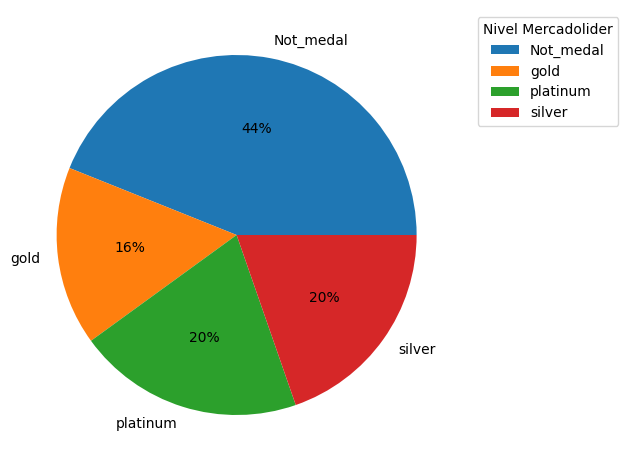

In [452]:
sellers_mercadolider=pd.DataFrame(100*df_sellers_raw.groupby(['seller_reputation+power_seller_status'])['seller_id'].count()/df_sellers_raw.groupby(['seller_reputation+power_seller_status'])['seller_id'].count().sum())
ax=sellers_mercadolider.plot.pie(y='seller_id',autopct='%.0f%%')
ax.legend(title='Nivel Mercadolider', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [453]:
sellers_mercadolider

,seller_id
seller_reputation+power_seller_status,
Not_medal,43.934426
gold,16.065574
platinum,20.327869
silver,19.672131


Distribución de Sellers por Semáforo de reputación.

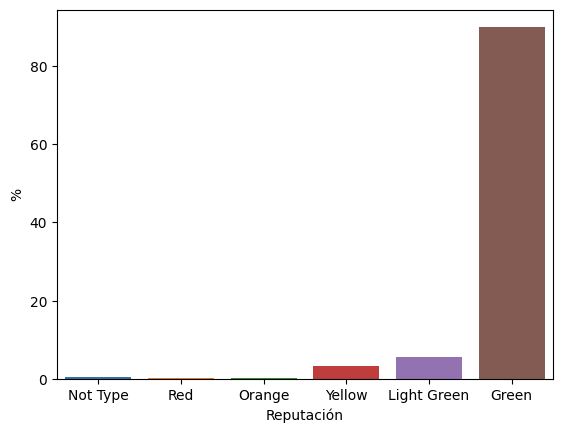

In [454]:
sellers_reputation=pd.DataFrame(100*df_sellers_raw.groupby(['seller_reputation+level_id'])['seller_id'].count()/df_sellers_raw.groupby(['seller_reputation+level_id'])['seller_id'].count().sum()).reset_index(drop=False)
ax=sns.barplot(x='seller_reputation+level_id',y='seller_id',data=sellers_reputation)
ax.set_xlabel('Reputación')
ax.set_ylabel('%')
plt.xticks(ticks=[0,1,2,3,4,5],labels=['Not Type','Red','Orange','Yellow','Light Green','Green'],rotation='horizontal')
plt.show()

In [455]:
sellers_reputation

,seller_reputation+level_id,seller_id
0,0_Not_type,0.655738
1,1_red,0.327869
2,2_orange,0.327869
3,3_yellow,3.278689
4,4_light_green,5.573770
5,5_green,89.836066


Distirbución de sellers por rango de madures y nivel de mercadolider

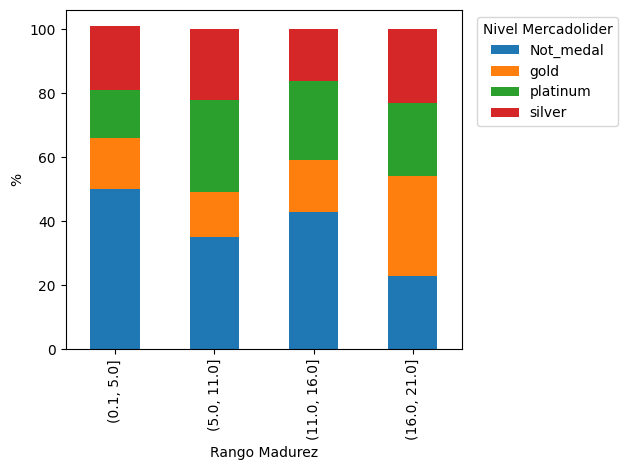

In [456]:
madurez_mercadolider=100*pd.crosstab(pd.cut(df_sellers_raw['years_antiquity'],bins=4,precision=0),df_sellers_raw['seller_reputation+power_seller_status'],normalize='index').round(2)
ax=madurez_mercadolider.plot.bar(stacked=True)
plt.xlabel('Rango Madurez')
plt.ylabel('%')
ax.legend(title='Nivel Mercadolider', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [457]:
madurez_mercadolider

seller_reputation+power_seller_status,Not_medal,gold,platinum,silver
years_antiquity,,,,
"(0.1, 5.0]",50.0,16.0,15.0,20.0
"(5.0, 11.0]",35.0,14.0,29.0,22.0
"(11.0, 16.0]",43.0,16.0,25.0,16.0
"(16.0, 21.0]",23.0,31.0,23.0,23.0


Distribución de sellers por semáforo de reputación y nivel de mercadolider

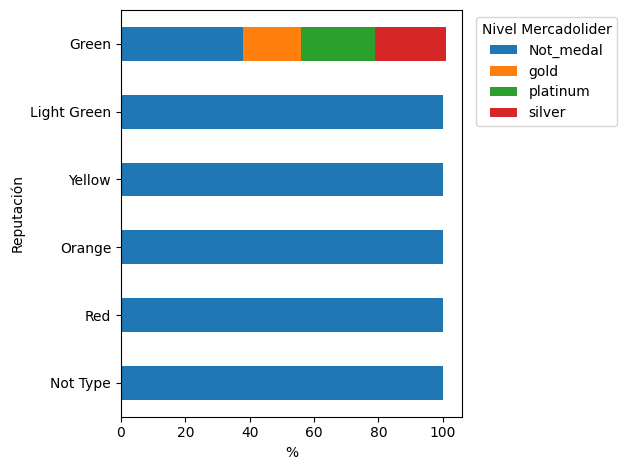

In [458]:
mercadolider_reputacion=100*(dh.summarise_categoric_variable(df_sellers_raw,'seller_reputation+level_id','seller_reputation+power_seller_status').set_index('seller_reputation+level_id')).round(2)
ax=mercadolider_reputacion.plot.barh(stacked=True)
plt.ylabel('Reputación')
plt.yticks(ticks=[0,1,2,3,4,5],labels=['Not Type','Red','Orange','Yellow','Light Green','Green'],rotation='horizontal')
plt.xlabel('%')
ax.legend(title='Nivel Mercadolider', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [459]:
mercadolider_reputacion

,Not_medal,gold,platinum,silver
seller_reputation+level_id,,,,
0_Not_type,100.0,0.0,0.0,0.0
1_red,100.0,0.0,0.0,0.0
2_orange,100.0,0.0,0.0,0.0
3_yellow,100.0,0.0,0.0,0.0
4_light_green,100.0,0.0,0.0,0.0
5_green,38.0,18.0,23.0,22.0


Distribución de sellers por etiqueta semáforo de reputación y total de ventas en los últimos 60 dias

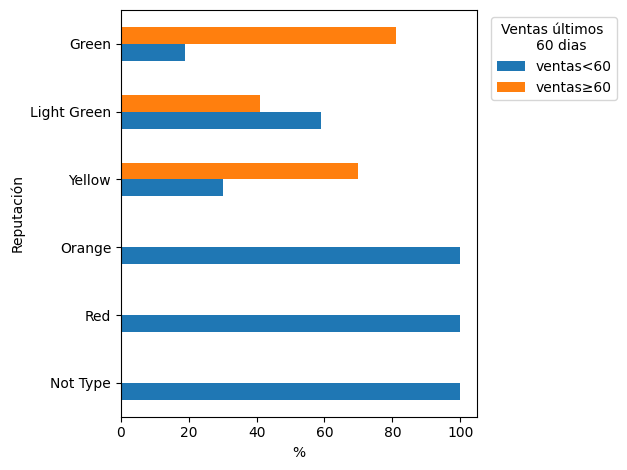

In [460]:
reputacion_periodo=100*(dh.summarise_categoric_variable(df_sellers_raw,'seller_reputation+level_id','seller_reputation+metrics+sales+period').set_index('seller_reputation+level_id')).round(2)
ax=reputacion_periodo.plot.barh(stacked=False)
plt.ylabel('Reputación')
plt.yticks(ticks=[0,1,2,3,4,5],labels=['Not Type','Red','Orange','Yellow','Light Green','Green'],rotation='horizontal')
plt.xlabel('%')
ax.legend(['ventas<60','ventas≥60'],title='Ventas últimos \n        60 dias', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

Distirbución de sellers por nivel de mercadolider y total de ventas en los últimos 60 dias

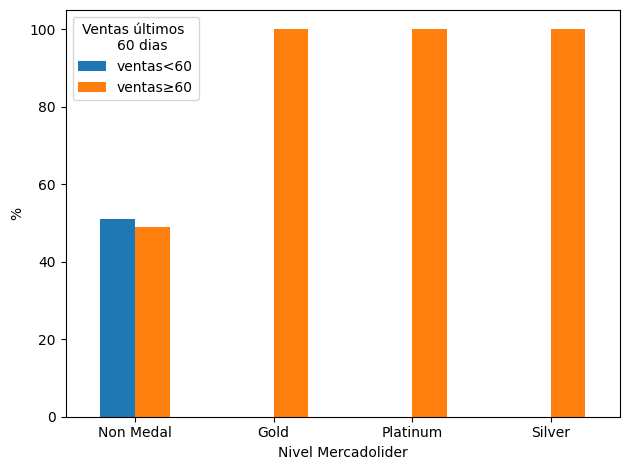

In [461]:
mercadolider_periodo=100*(dh.summarise_categoric_variable(df_sellers_raw,'seller_reputation+power_seller_status','seller_reputation+metrics+sales+period').set_index('seller_reputation+power_seller_status')).round(2)
ax=mercadolider_periodo.plot.bar(stacked=False)
plt.xlabel('Nivel Mercadolider')
plt.xticks(ticks=[0,1,2,3],labels=['Non Medal','Gold','Platinum','Silver'],rotation='horizontal')
plt.ylabel('%')
ax.legend(['ventas<60','ventas≥60'],title='Ventas últimos \n        60 dias', loc='upper left')
plt.tight_layout()
plt.show()

In [462]:
mercadolider_periodo

,365 days,60 days
seller_reputation+power_seller_status,,
Not_medal,51.0,49.0
gold,0.0,100.0
platinum,0.0,100.0
silver,0.0,100.0


Distribución del cuantil 90 de los descuentos por nivel de mercado lider

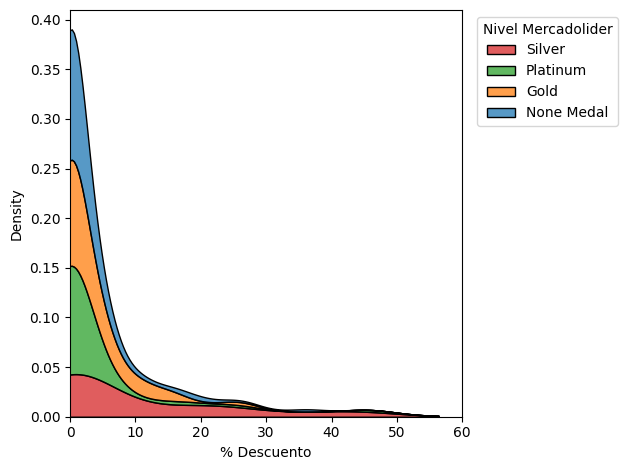

In [463]:
ax=sns.kdeplot(data=df_sellers_raw,x='q90_discount',hue='seller_reputation+power_seller_status',multiple='stack',common_norm=False)
ax.set_xlim(0,60)
plt.xlabel('% Descuento')
ax.legend(['Silver','Platinum','Gold','None Medal'],title='Nivel Mercadolider', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

Distribución de rangos deñ total de items vendidos por rango de descuento

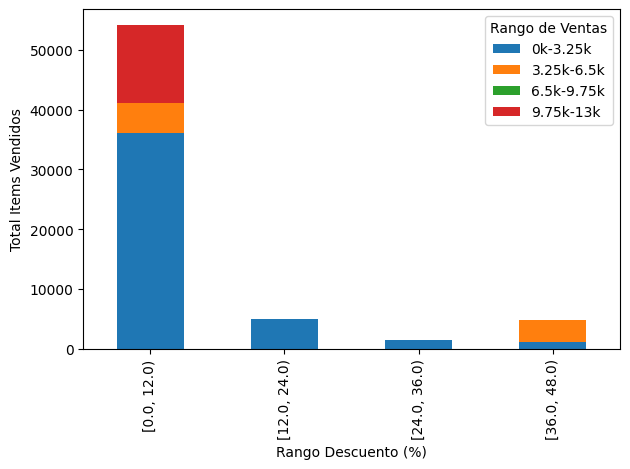

In [464]:
descuento_ventas=pd.pivot_table(data=df_sellers_raw,values='sold_items',index=pd.cut(df_sellers_raw['q90_discount'],right=False,bins=4,precision=0),columns=pd.cut(df_sellers_raw['sold_items'],right=False,bins=4,precision=0),dropna=False,fill_value=0, aggfunc='sum').round(1)
ax=descuento_ventas.plot(kind='bar', stacked=True)
plt.xlabel('Rango Descuento (%)')
plt.ylabel('Total Items Vendidos')
ax.legend(['0k-3.25k','3.25k-6.5k','6.5k-9.75k','9.75k-13k'],title='Rango de Ventas', loc='upper right')
plt.tight_layout()
plt.show()

In [465]:
descuento_ventas

sold_items,"[0.0, 3250.0)","[3250.0, 6500.0)","[6500.0, 9750.0)","[9750.0, 13013.0)"
q90_discount,,,,
"[0.0, 12.0)",36113,5000,0,13000
"[12.0, 24.0)",4883,0,0,0
"[24.0, 36.0)",1454,0,0,0
"[36.0, 48.0)",1024,3764,0,0


Transformación de información de sellers para modelado, incluyendo generación de variables indicadoras para variables categóricas como Semáforo de reputación, periodo de evaluación métricas y nivel de mercadolider

In [466]:
df_sellers=dh.transform_df_items(df_items=df_items)
print(df_sellers.shape)
df_sellers.head()

(305, 32)


,seller_id,years_antiquity,n_items,n_subcategories,sold_items,mean_intallments,q10_discount,q50_discount,q90_discount,total_transactions,...,seller_reputation+power_seller_status-platinum,seller_reputation+power_seller_status-silver,seller_reputation+level_id-0_Not_type,seller_reputation+level_id-1_red,seller_reputation+level_id-2_orange,seller_reputation+level_id-3_yellow,seller_reputation+level_id-4_light_green,seller_reputation+level_id-5_green,seller_reputation+metrics+sales+period-365 days,seller_reputation+metrics+sales+period-60 days
0,1066358,16.602327,1,1,2,12.0,0.000000,0.00000,0.000000,1183,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,3637758,16.375086,1,1,5,36.0,0.000000,0.00000,0.000000,3083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,4944181,11.359343,1,1,0,36.0,10.000000,10.00000,10.000000,357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,6818277,16.219028,1,1,5,36.0,0.000000,0.00000,0.000000,364,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,8019088,21.349760,2,1,51,36.0,0.500006,2.50003,4.500055,5502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [467]:
df_clust=df_sellers[[c for c in df_sellers.columns if c not in ['seller_id']]]

Escalado de variables con MinMaxScaler:
$$
x^{'}_{i}=\frac{x_i-min(x)}{max(x)-min(x)}
$$
Posteriormente se exporta el objeto para escalarnuevas observaciones.

In [468]:
scaler=MinMaxScaler()
scaler.fit(df_clust)
joblib.dump(scaler,'scaler.sav')

['scaler.sav']

Se importa nuevamente el objeto para ser usado en el modelado y escalar las variables.

In [469]:
scaler=joblib.load('scaler.sav')

In [470]:
df_scaled=pd.DataFrame(scaler.transform(df_clust),columns=scaler.get_feature_names_out()).set_index(df_sellers.seller_id)
df_scaled.head()

,years_antiquity,n_items,n_subcategories,sold_items,mean_intallments,q10_discount,q50_discount,q90_discount,total_transactions,completed_transactions,...,seller_reputation+power_seller_status-platinum,seller_reputation+power_seller_status-silver,seller_reputation+level_id-0_Not_type,seller_reputation+level_id-1_red,seller_reputation+level_id-2_orange,seller_reputation+level_id-3_yellow,seller_reputation+level_id-4_light_green,seller_reputation+level_id-5_green,seller_reputation+metrics+sales+period-365 days,seller_reputation+metrics+sales+period-60 days
seller_id,,,,,,,,,,,,,,,,,,,,,
1066358,0.776633,0.00,0.0,0.000154,0.0,0.000000,0.000000,0.000000,0.001194,0.001178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3637758,0.765941,0.00,0.0,0.000385,1.0,0.000000,0.000000,0.000000,0.003117,0.003111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4944181,0.529950,0.00,0.0,0.000000,1.0,0.285714,0.248876,0.208969,0.000358,0.000342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
6818277,0.758598,0.00,0.0,0.000385,1.0,0.000000,0.000000,0.000000,0.000365,0.000375,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8019088,1.000000,0.02,0.0,0.003923,1.0,0.014286,0.062220,0.094037,0.005565,0.005385,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


* Algoritmos de clusterización (No supervisado)

Obtención de métricas para la selección del valor óptimo de clusters para algoritmo Kmeans y cluster jerarquico

{'silhoutte': 15,
 'similitud_ Davies-Bouldin': 12,
 'Cohesion_calinski-harabasz': 9}

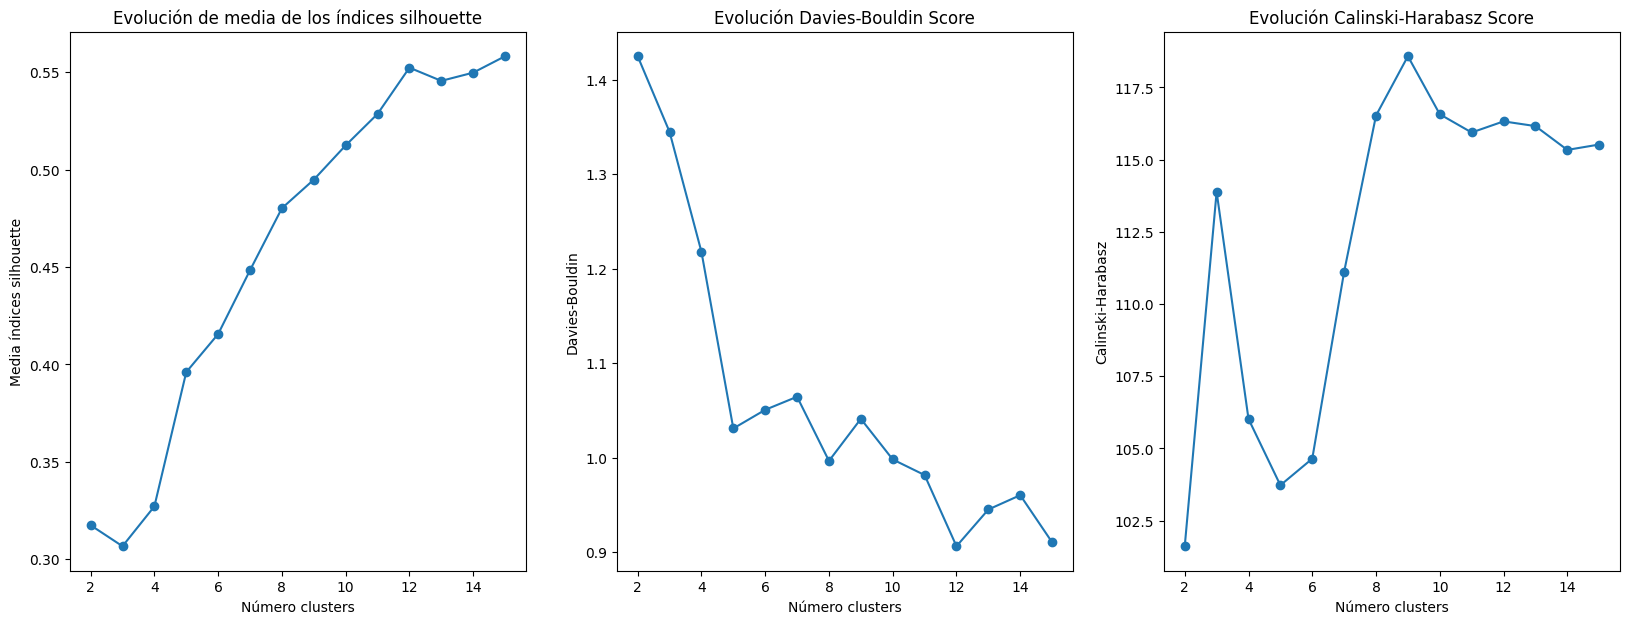

In [471]:
hier_metrics=dm.hierarchical_clustering_analysis(df_scaled=df_scaled,range_n_clusters=range(2,16))
hier_metrics

Dendograma para visualizar altura de corte y selección decantidad de clusters

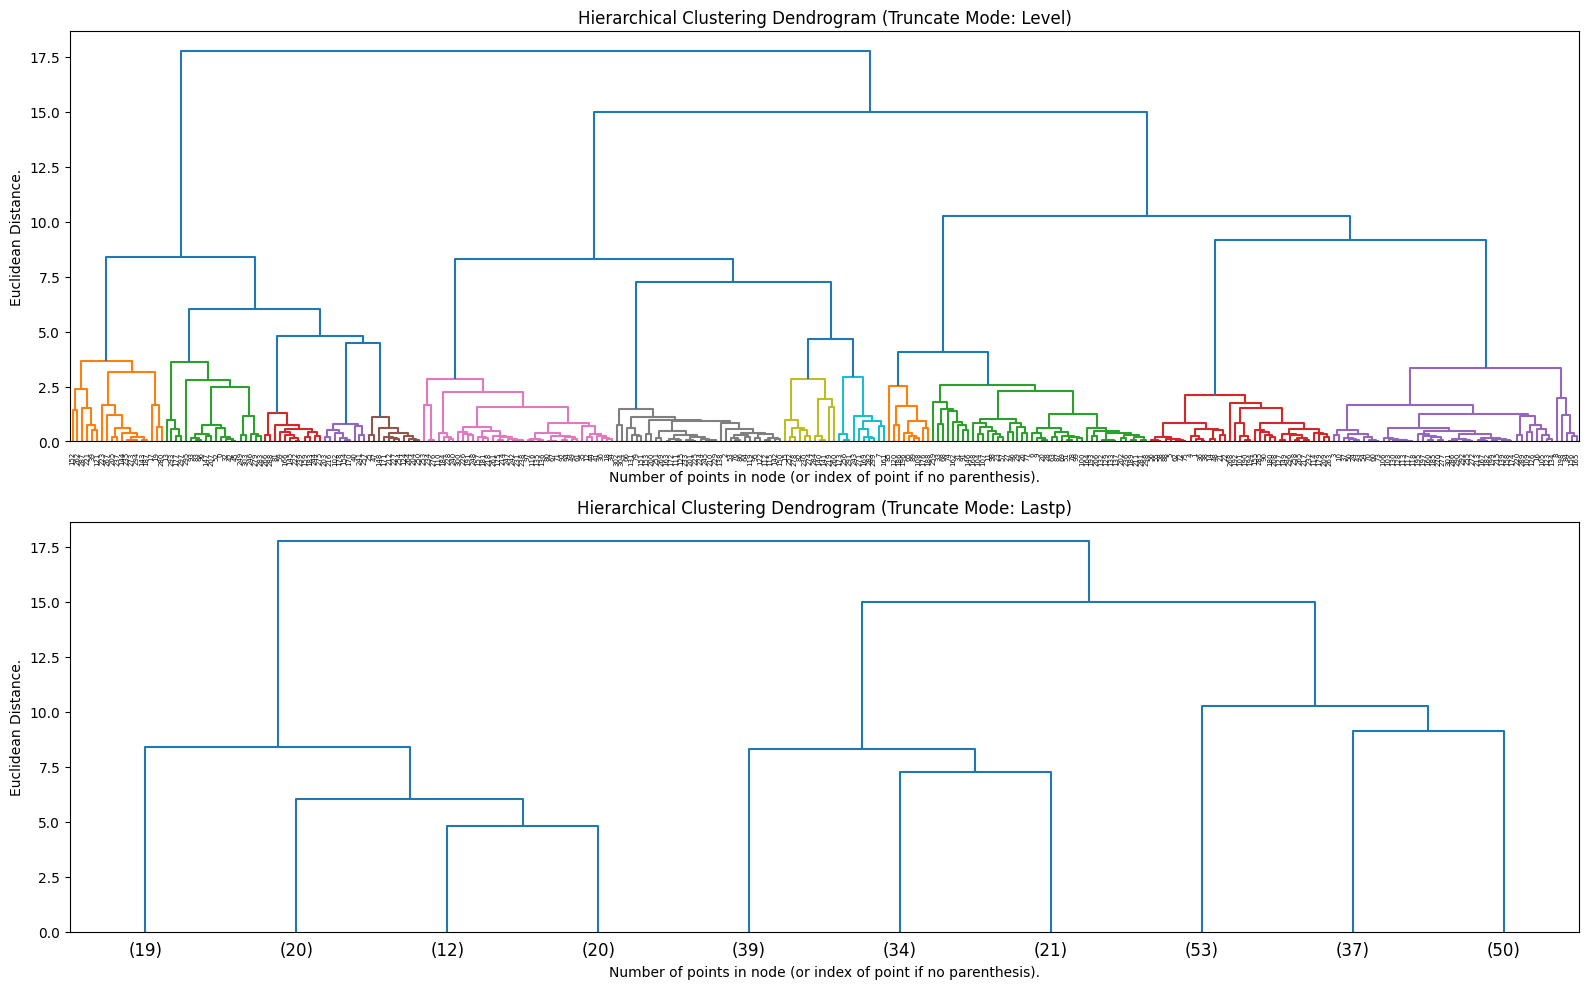

In [472]:
modelo_hclust_ward = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'ward',
                            distance_threshold = 0,
                            n_clusters         = None
                     )
modelo_hclust_ward.fit(X=df_scaled)

plt.figure(figsize=(16,10))

plt.subplot(2, 1, 1)
plt.title("Hierarchical Clustering Dendrogram (Truncate Mode: Level)")
dm.plot_dendrogram(modelo_hclust_ward, color_threshold=3.75, truncate_mode='level')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Euclidean Distance.")

plt.subplot(2, 1, 2)
plt.title("Hierarchical Clustering Dendrogram (Truncate Mode: Lastp)")
dm.plot_dendrogram(modelo_hclust_ward, color_threshold=3.75, truncate_mode='lastp', p=10)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Euclidean Distance.")
plt.tight_layout()
plt.show()

{'elbow': 7,
 'silhoutte': 15,
 'similitud_ Davies-Bouldin': 11,
 'Cohesion_calinski-harabasz': 7}

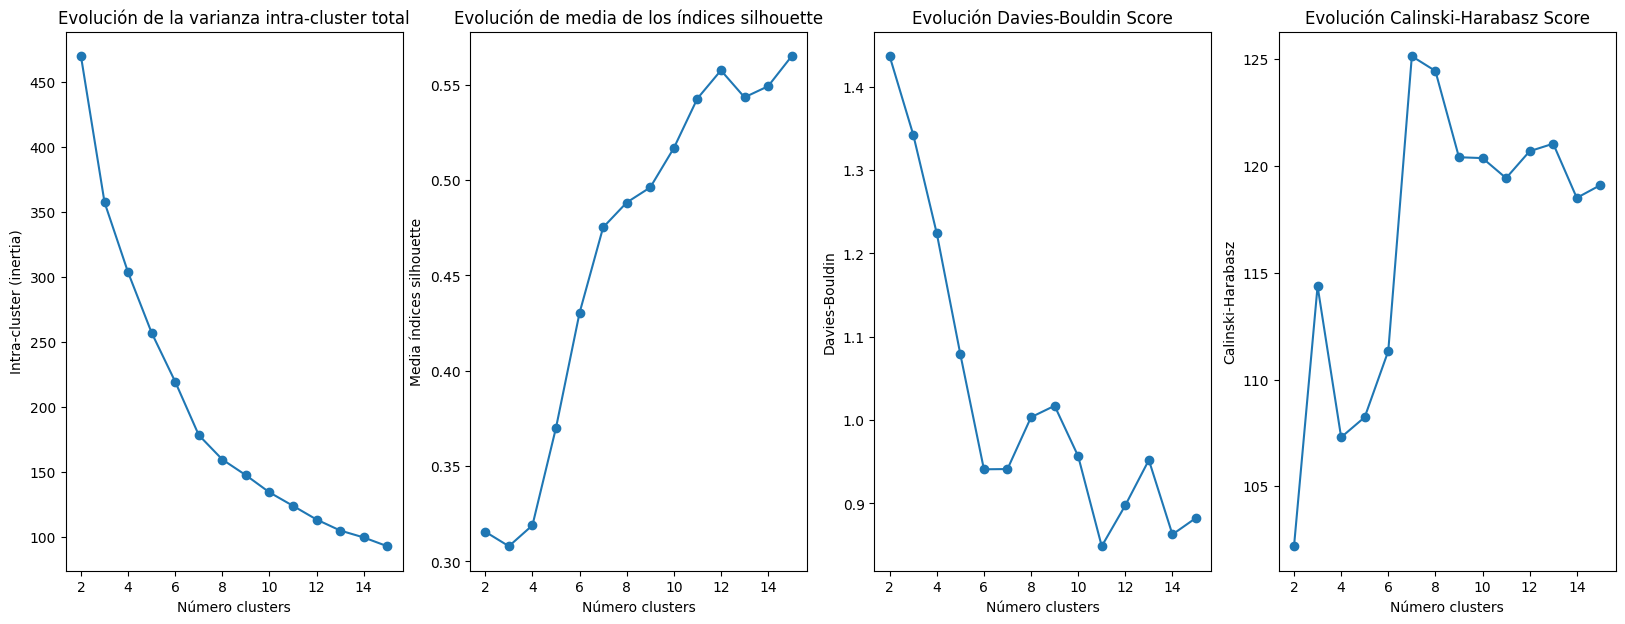

In [473]:
km_metrics=dm.kmeans_clustering_analysis(df_scaled=df_scaled,range_n_clusters=range(2,16))
km_metrics

Selección de cantidad de clusters óptima tomando cómo métricas de evaluación:
- Inercia (Método de codo-Kmeans): Se busca encontrar el número de cluster de tal manera que haya un cambio no suave de una cantidad de clusters a la siguiente.
- Coeficiente de silueta [-1,1]: Cuando el valor es el mayor inidica que los clusters están bien separados y son uniformes internamente. 
- Coeficiente de cohesión (calinski-harabasz) : Es el cociente de la variabilidad entre clusters y la variación dentro de los clusters, un valor alto indica cluster bien separados y uniformes internamente.  
- Coeficiente de similitud (Davies-Bouldin) (0,$\infty$): Mide la similaridad promedio entre clusters, valores cercanos a ceros indican mejor partición. 

Se toma como cantidad óptima de cluster a la mediana entre los valores óptimos por Kmeans y Cluster Jerarquico.

In [474]:
k=(np.median(([c for c in hier_metrics.values()]+[c for c in km_metrics.values()]))-1).astype(int)
k

10

Entrenamiento y almacenamiento de Modelo de cluster final para asignación de cluster a nuevos individuos.

In [475]:
cluster_model_final=KMeans(n_clusters=k,n_init= 20,random_state = 123)
cluster_model_final.fit(df_scaled)
joblib.dump(cluster_model_final,'model.sav')

['model.sav']

Carga del Modelo entrenado para generar etiqueta de pertenencia a cluster.

In [476]:
model=joblib.load('model.sav')
labels=model.predict(df_scaled)
df_sellers_raw['label']=labels
df_sellers_raw.to_csv('MELI_sellers.csv',sep=';',index=False)

* Caracterización de clusters

Tamaños de cluster

In [477]:
cluster_cantidad=pd.DataFrame({'%Size':100*(df_sellers_raw['label'].value_counts(dropna=False)/df_sellers_raw['label'].value_counts(dropna=False).sum()).round(2)})
cluster_cantidad.insert(loc=0,column='Size',value=df_sellers_raw['label'].value_counts(dropna=False), allow_duplicates=True)
cluster_cantidad=cluster_cantidad.sort_index(axis=0)
cluster_cantidad

,Size,%Size
label,,
0,37,12.0
1,34,11.0
2,20,7.0
3,44,14.0
4,53,17.0
5,49,16.0
6,18,6.0
7,12,4.0
8,16,5.0


Una manera de evaluar la similaridad y variabilidad de individuos de un cluster en especifico es comparar el coeficiente de variación de cada cluster para variables númericas y compararle con el coeficiente de variación de la variable sin tener en cuenta los clusters, con lo que se espera una disminución de estos valores en cada cluster respecto a la población total, con el coeficiente de variación dado por:

$$
CV(x)=\left|\frac{s_x}{\bar{x}}\right|
$$

Con $s_x$ y $\bar{x}$ la desviación estandar y la media de la variable $x$ respectivamente.

Adicional a esto se calcula algunas medidas características para estas variables como el mínimo, máximo y promedio de la variable en cada cluster.

Caracterización items vendidos por cada cluster

In [478]:
dm.cluster_characterization_numeric_var(df=df_sellers_raw,str_var='sold_items')

,grupo,cv_grupo,cv_total,dif%_cv,min,max,mean
0,0,1.915835,4.065467,-52.875416,0,1440,141.945946
1,1,2.702106,4.065467,-33.535166,0,755,50.588235
2,2,1.469537,4.065467,-63.853174,0,2250,392.200000
3,3,2.308035,4.065467,-43.228299,0,137,10.136364
4,4,2.789969,4.065467,-31.373959,0,13000,661.773585
5,5,2.102961,4.065467,-48.272588,0,500,50.081633
6,6,1.276975,4.065467,-68.589712,0,57,12.944444
7,7,0.784315,4.065467,-80.707883,5,1000,393.750000
8,8,2.983762,4.065467,-26.607153,0,383,31.562500
9,9,3.359309,4.065467,-17.369660,0,5000,317.500000


Caracterización cuantil al 10% de descuento en cada grupo

In [479]:
dm.cluster_characterization_numeric_var(df=df_sellers_raw,str_var='q10_discount')

,grupo,cv_grupo,cv_total,dif%_cv,min,max,mean
0,0,2.712827,2.694488,0.680609,0.0,26.026026,1.865568
1,1,3.487935,2.694488,29.447037,0.0,35.000000,1.786626
2,2,2.520748,2.694488,-6.448008,0.0,8.000000,0.900175
3,3,2.860319,2.694488,6.154451,0.0,23.335926,2.035296
4,4,1.866437,2.694488,-30.731317,0.0,26.860227,4.410770
5,5,3.472465,2.694488,28.872890,0.0,34.036787,1.746564
6,6,3.480499,2.694488,29.171067,0.0,21.200000,1.455556
7,7,1.124880,2.694488,-58.252562,0.0,15.000000,4.166865
8,8,3.630298,2.694488,34.730508,0.0,5.000000,0.343750
9,9,2.588827,2.694488,-3.921404,0.0,10.000000,1.000782


Caracterización cuantil al 90% del descuento en cada grupo

In [480]:
dm.cluster_characterization_numeric_var(df=df_sellers_raw,str_var='q90_discount')

,grupo,cv_grupo,cv_total,dif%_cv,min,max,mean
0,0,2.038173,2.292167,-11.080954,0.0,26.026026,2.865578
1,1,2.371985,2.292167,3.482203,0.0,35.000000,2.877802
2,2,1.741348,2.292167,-24.030486,0.0,8.000000,1.487996
3,3,2.499119,2.292167,9.028653,0.0,23.335926,2.410296
4,4,1.382735,2.292167,-39.675645,0.0,47.854022,10.573673
5,5,3.616972,2.292167,57.797058,0.0,46.324587,2.225183
6,6,3.741978,2.292167,63.250671,0.0,37.000000,2.333333
7,7,1.124880,2.292167,-50.925049,0.0,15.000000,4.166865
8,8,2.246953,2.292167,-1.972532,0.0,16.670140,1.948134
9,9,2.455087,2.292167,7.107660,0.0,27.669805,2.585773


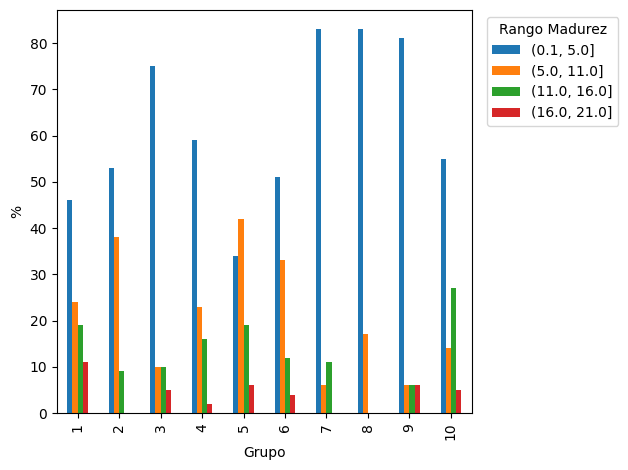

In [481]:
cluster_madurez=100*pd.crosstab(df_sellers_raw['label']+1,pd.cut(df_sellers_raw['years_antiquity'],bins=4,precision=0),normalize='index').round(2)
ax=cluster_madurez.plot.bar(stacked=False)
plt.xlabel('Grupo')
plt.ylabel('%')
ax.legend(title='Rango Madurez', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [482]:
100*pd.crosstab(df_sellers_raw['label']+1,pd.cut(df_sellers_raw['years_antiquity'],bins=4,precision=0),normalize='index',margins=True).round(2)

years_antiquity,"(0.1, 5.0]","(5.0, 11.0]","(11.0, 16.0]","(16.0, 21.0]"
label,,,,
1,46.0,24.0,19.0,11.0
2,53.0,38.0,9.0,0.0
3,75.0,10.0,10.0,5.0
4,59.0,23.0,16.0,2.0
5,34.0,42.0,19.0,6.0
6,51.0,33.0,12.0,4.0
7,83.0,6.0,11.0,0.0
8,83.0,17.0,0.0,0.0
9,81.0,6.0,6.0,6.0


<Axes: xlabel='label', ylabel='sold_items'>

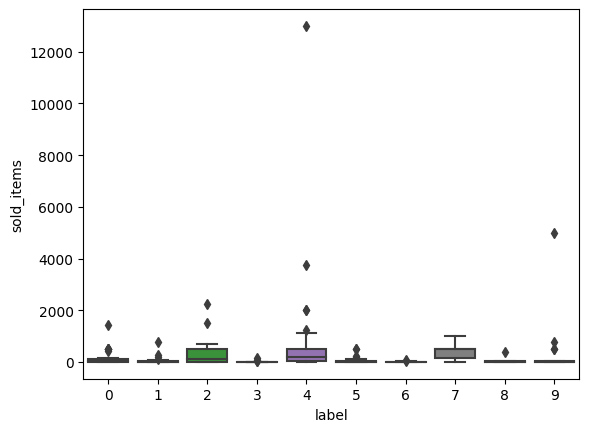

In [483]:
sns.boxplot(data=df_sellers_raw,y='sold_items',x='label')

<Axes: xlabel='label', ylabel='q90_discount'>

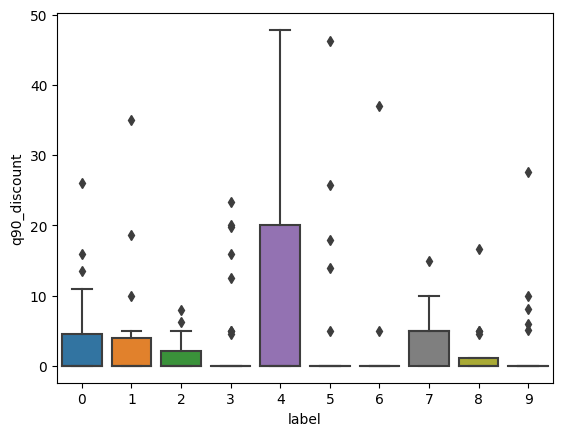

In [484]:
sns.boxplot(data=df_sellers_raw,y='q90_discount',x='label')

<Axes: xlabel='label', ylabel='years_antiquity'>

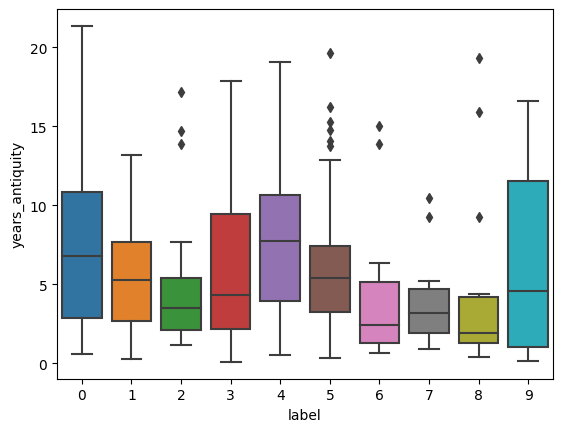

In [485]:
sns.boxplot(data=df_sellers_raw,y='years_antiquity',x='label')

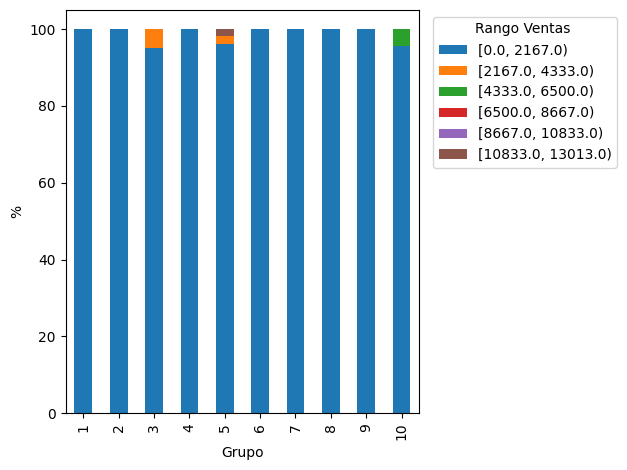

In [486]:
cluster_ventas=100*pd.crosstab(df_sellers_raw['label']+1,pd.cut(df_sellers_raw['sold_items'],right=False,bins=6,precision=0),normalize='index',dropna=False).round(3)
ax=cluster_ventas.plot.bar(stacked=True)
plt.xlabel('Grupo')
plt.ylabel('%')
ax.legend(title='Rango Ventas ', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [487]:
100*pd.crosstab(df_sellers_raw['label']+1,pd.cut(df_sellers_raw['sold_items'],right=False,bins=6,precision=0),normalize='index',dropna=False,margins=True)

sold_items,"[0.0, 2167.0)","[2167.0, 4333.0)","[4333.0, 6500.0)","[6500.0, 8667.0)","[8667.0, 10833.0)","[10833.0, 13013.0)"
label,,,,,,
1,100.000000,0.000000,0.000000,0.0,0.0,0.000000
2,100.000000,0.000000,0.000000,0.0,0.0,0.000000
3,95.000000,5.000000,0.000000,0.0,0.0,0.000000
4,100.000000,0.000000,0.000000,0.0,0.0,0.000000
5,96.226415,1.886792,0.000000,0.0,0.0,1.886792
6,100.000000,0.000000,0.000000,0.0,0.0,0.000000
7,100.000000,0.000000,0.000000,0.0,0.0,0.000000
8,100.000000,0.000000,0.000000,0.0,0.0,0.000000
9,100.000000,0.000000,0.000000,0.0,0.0,0.000000


Con el fin de caracterizar los clusters se calcula la distribución de las categorias de variables categóricas en cada cluster y evaluar la partición así cómo puntos claves de identificación y clasificación del cluster

Distribución Nivel mercadolider en cada cluster

In [488]:
100*(dh.summarise_categoric_variable(df_sellers_raw,'label','seller_reputation+power_seller_status').set_index('label')).round(2)

,Not_medal,gold,platinum,silver
label,,,,
0,0.0,100.0,0.0,0.0
1,100.0,0.0,0.0,0.0
2,0.0,0.0,45.0,55.0
3,100.0,0.0,0.0,0.0
4,0.0,0.0,100.0,0.0
5,0.0,0.0,0.0,100.0
6,100.0,0.0,0.0,0.0
7,0.0,100.0,0.0,0.0
8,100.0,0.0,0.0,0.0


Distribución Semáforo de reputación en cada cluster

In [489]:
100*(dh.summarise_categoric_variable(df_sellers_raw,'label','seller_reputation+level_id').set_index('label')).round(2)

,0_Not_type,1_red,2_orange,3_yellow,4_light_green,5_green
label,,,,,,
0,0.0,0.0,0.0,0.0,0.0,100.0
1,0.0,0.0,0.0,0.0,0.0,100.0
2,0.0,0.0,0.0,0.0,0.0,100.0
3,0.0,2.0,2.0,7.0,0.0,89.0
4,0.0,0.0,0.0,0.0,0.0,100.0
5,0.0,0.0,0.0,0.0,0.0,100.0
6,11.0,0.0,0.0,0.0,22.0,67.0
7,0.0,0.0,0.0,0.0,0.0,100.0
8,0.0,0.0,0.0,19.0,81.0,0.0


Distribución periodo de evaluación métricas en cada cluster

In [490]:
100*(dh.summarise_categoric_variable(df_sellers_raw,'label','seller_reputation+metrics+sales+period').set_index('label')).round(2)

,365 days,60 days
label,,
0,0.0,100.0
1,0.0,100.0
2,0.0,100.0
3,100.0,0.0
4,0.0,100.0
5,0.0,100.0
6,100.0,0.0
7,0.0,100.0
8,38.0,62.0


Una explicación mas detallada de la caracterización y hallazgos importantes de la información de sellers se encuentran en el archivo Meli_Challenge.pptx